# Cats and Dogs project - classifing pictures without neural networks

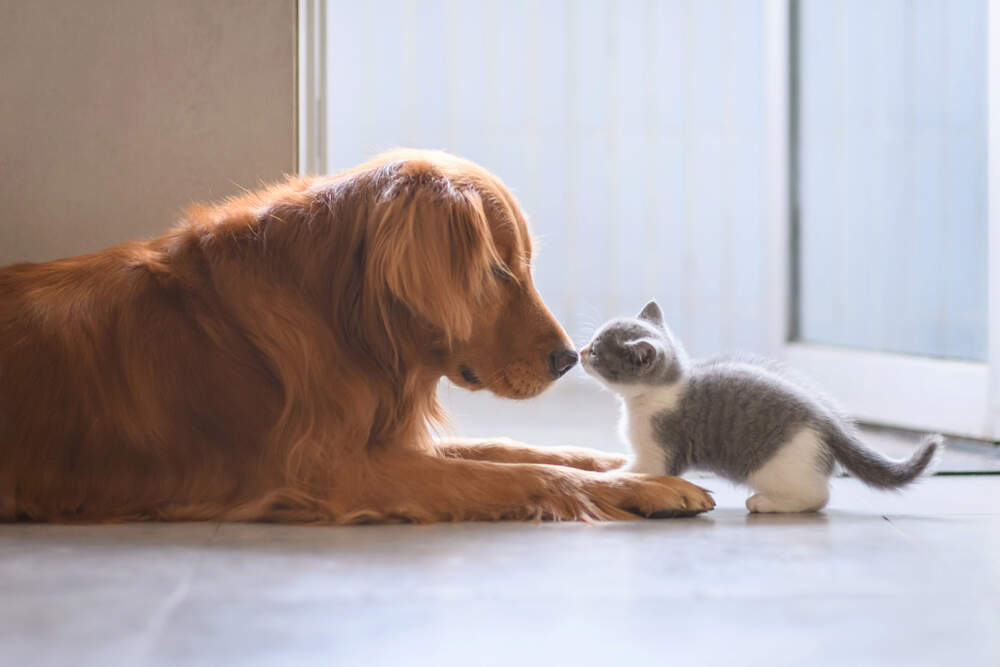

In this project we were asked to take the Cats and Dogs data set and to try to give the best prediction based on the models we learned in class, without using neural networks.

### Table of Contents:
    1. Getting to know the data, train test split, pca.
    2. Sampling models:
        a. knn classifier + grid search
        b. svc
        c. random forest classifier
        d. voting classifier
    3. comparing models scores and choosing the final model

## Getting to know the data, train test split, pca:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
plt.style.use('seaborn')

from matplotlib.image import imread
from PIL import Image
from os import listdir
from numpy import asarray

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier


import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

Just before we started working on the data set, we wanted to have a look on the pictures in the data. we've noticed that the pictures are in different sizes. Thus, we resized them all to be at the same shape. Moreover, we converted all the photos to black so it'll have fewer dimentions.

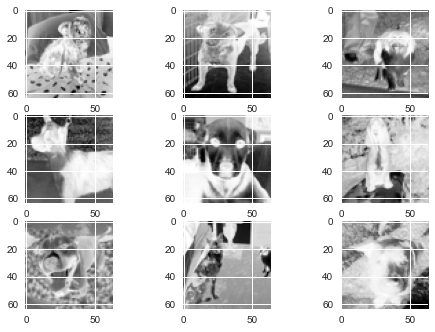

In [3]:
folder = 'C:\\אריאל\\שנה א\\סמסטר ב\\הדמיית נתונים\\Data_visualization_project\\Cats Vs Dogs\\train\\'
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    filename = folder + 'dog.' + str(i) + '.jpg'
    image = Image.open(filename).resize((64, 64)).convert('L')
    pyplot.imshow(image)
display()

We loaded the pictures from the computer, then reshaped the pictures to be 2 dimentional, moved all the pixels to be in the range between 0 to 1 and splitted the data to train and test set.

In [4]:
folder = 'C:\\אריאל\\שנה א\\סמסטר ב\\הדמיית נתונים\\Data_visualization_project\\Cats Vs Dogs\\train\\'
photos, labels = list(), list()
count = 0
for image in listdir(folder):
    #print(count)
    output = 0
    if image.startswith('cat'):
        output = 1
    vec = asarray(Image.open(folder + image).resize((64, 64)).convert('L'))
    photos.append(vec)
    labels.append(output)
    count +=1

In [13]:
pictures = np.array(photos)

In [14]:
pictures = np.reshape(pictures, (25000, 64*64))
pictures = pictures/255

In [15]:
X_train, X_test, y_train, y_test = train_test_split(pictures, labels, test_size=0.1, random_state=42)

In [17]:
X_train.shape

(22500, 4096)

After making the intial transormation to the data, we wanted to reduce the number of dimention in each picture. Thus, we used PCA.

In [8]:
pca = PCA(n_components=0.95)
train = pca.fit_transform(X_train)

In [9]:
train.shape

(22500, 414)

As we can see, the number of the pixels in each photo dropped to 414! By preserving only 95% of the variance, the number of features dropped to about ten precent of the original number of features.

## Sampling models:
### a. knn classifier + grid search
Knn is a model that searches by given parameters the closest n neighbors of an item

Text(0, 0.5, 'Testing Accuracy')

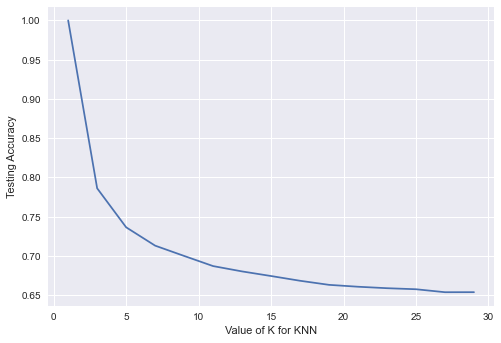

In [10]:
k_range = list(range(1, 31, 2))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train, y_train)
    pred = knn.predict(train)
    scores.append(metrics.accuracy_score(y_train, pred))
    
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

We can see that at about the difference between k=15 to k=30 is not that big, and thus we'll check only 'till this number.

In [11]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

k_range = list(range(1, 17, 2))
k_mean_scores = []
k_std_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=kf, scoring='accuracy')
    k_mean_scores.append(scores.mean())
    k_std_scores.append(scores.std())

d = {'k_mean': k_mean_scores, 'k_std': k_std_scores}
Ks = pd.DataFrame(data = d, index=k_range)

In [12]:
Ks['k_mean'].sort_values(ascending=False)

15    0.593867
13    0.592933
11    0.588044
9     0.587511
7     0.582089
5     0.579022
3     0.568489
1     0.554089
Name: k_mean, dtype: float64

In [13]:
Ks['k_std'].sort_values(ascending=True)

7     0.008265
15    0.008835
9     0.008892
13    0.009204
5     0.009588
11    0.009927
1     0.010946
3     0.011003
Name: k_std, dtype: float64

It seems that the best k to choose is k=15 (best score, and second smallest std). we'll verify that using grid search.

In [14]:
knn=KNeighborsClassifier()
k_range = list(range(3,17,2))
print(k_range)
weight_options = ['uniform', 'distance']
metrics_options = ['euclidean', 'manhattan']
param_grid = dict(n_neighbors=k_range, weights=weight_options, metric=metrics_options)
grid=GridSearchCV(knn, param_grid, cv=kf, scoring='accuracy')
print("getting to fit")
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)

[3, 5, 7, 9, 11, 13, 15]
getting to fit
0.607777777777778
{'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}


In [15]:
X_traina, X_trainb, y_traina, y_trainb = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

### b. SVC

SVC is the classifier of SVM (support vector machine). It is based on logistic regression, but finds the line that keeps the biggest distance from each one of the labels.

In [16]:
svc = SVC()
svc.fit(X_traina, y_traina)
svc.score(X_trainb, y_trainb)
#scoresvc = cross_val_score(svc, X_train, y_train, cv=kf, scoring='accuracy')
#print(scoresvc.mean())
#print(scoresvc.std())

0.6791111111111111

### c. Random Forest Classifier

Random forest classifier is a model that creates a couple of binary trees, trying with the data set that has been given a random few of them and chooses the one that performed best.

In [17]:
rfc = RandomForestClassifier()
rfc.fit(X_traina, y_traina)
rfc.score(X_trainb, y_trainb)
#scoresrfc = cross_val_score(rfc, X_train, y_train, cv=kf, scoring='accuracy')
#print(scoresrfc.mean())
#print(scoresrfc.std())

0.6564444444444445

### d. Voting Classifier

The Voting Classifier model is using other model and makes a vote between them. In it's base, the labek that most of the models voted to is the label that the Voting Classifier will return.

In [18]:
knn = KNeighborsClassifier(n_neighbors=15, weights='distance', metric='manhattan')
svca = SVC(probability=True)
voting_clf = VotingClassifier(
    estimators=[('knn', knn), ('svc', svca), ('rfc', rfc)],
    voting='soft')
voting_clf.fit(X_traina, y_traina)

VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=13)),
                             ('svc', SVC(probability=True)),
                             ('rfc', RandomForestClassifier())],
                 voting='soft')

In [19]:
for clf in (knn, svca, rfc, voting_clf):
    clf.fit(X_traina, y_traina)
    #y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, clf.score(X_trainb, y_trainb))

KNeighborsClassifier 0.6075555555555555
SVC 0.6791111111111111
RandomForestClassifier 0.6453333333333333
VotingClassifier 0.6622222222222223


### The model that gave the best results id the SVC model (67.9%). Thus, we'll choose it to be our final model.

## Apllying the  testing on the model

In [9]:
test = pca.transform(X_test)

In [12]:
svc.fit(train, y_train)
final_predict = svc.predict(test)
print('Final accuracy score of model is: ', accuracy_score(y_test,final_predict))

Final accuracy score of model is:  0.6488
